In [1]:
import os
import numpy as np
from statistics import mean

import torch
import torchvision

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy import stats

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

PROJECT_PATH = os.getenv('HOME') + '/aiffel/0_felton'
MODEL_PATH = os.path.join(PROJECT_PATH, 'weights')
DATA_PATH = os.path.join(PROJECT_PATH, 'data_ex')
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')
REJECT_PATH = os.path.join(DATA_PATH, 'reject')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # 여기서 'cuda'가 출력되어야 GPU와 연결이 됩니다

cuda


In [ ]:
# train path image 확인 각폴더당 1개
for dirpath, dirnames, filenames in os.walk(TRAIN_PATH):
    for i, filename in enumerate(filenames):
        print(os.path.join(dirpath, filename)) # 파일이름을 출력합니다
        image = Image.open(os.path.join(dirpath, filename), 'r')
        print(f'size: ({image.width}, {image.height}, {image.getbands()})') # 이미지 정보를 출력합니다
        plt.imshow(image)
        plt.show()
        break # 폴더마다 1장만 출력합니다

In [ ]:
# reject foler image 확인 5개
for dirpath, dirnames, filenames in os.walk(REJECT_PATH):
    for i, filename in enumerate(filenames):
        if i > 4:
            break
        print(os.path.join(dirpath, filename))
        image = Image.open(os.path.join(dirpath, filename), 'r')
        print(f'size: ({image.width}, {image.height}, {image.getbands()})')
        plt.imshow(image)
        plt.show()

In [4]:
# data 전처리 함수 만들기 resize 224, 224 -> resNet 사용 shape조절

# train data image 증강
# random H-flip, V-flip image 증강
# 색깔 바꾸기 colorjitter 
# center crop 사용안함

def create_dataloader(path, batch_size, istrain):
    nearest_mode = torchvision.transforms.InterpolationMode.NEAREST
    normalize = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
    )
    train_transformer = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224), interpolation=nearest_mode),
#         torchvision.transforms.CenterCrop((224,224)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ColorJitter(),
        torchvision.transforms.ToTensor(),
        normalize
    ])

    test_transformer = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224), interpolation=nearest_mode),
#         torchvision.transforms.CenterCrop((224,224)),
        torchvision.transforms.ToTensor(),
        normalize
    ])
    
    if istrain:
        data = torchvision.datasets.ImageFolder(path, transform=train_transformer)
        dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        
    else:
        data = torchvision.datasets.ImageFolder(path, transform=test_transformer)
        dataloader = torch.utils.data.DataLoader(data, shuffle=False)

    return dataloader, data


In [5]:
# 위에서 만든 함수로 데이터셋 준비
# train dataset
# batch_size = 32

BATCH_SIZE = 32

train_loader, _train_data = create_dataloader(TRAIN_PATH, BATCH_SIZE, True)
target_class_num = len(os.listdir(os.path.join(TRAIN_PATH)))

print('target_class_num: ', target_class_num)
print('train: ', _train_data.class_to_idx)

target_class_num:  3
train:  {'07_inner_cupholder_resized1': 0, '07_inner_cupholder_resized2': 1, '07_inner_cupholder_resized3': 2}


In [6]:
# 각 클래스별 이미지 개수 확인
for dirpath, dirnames, filenames in os.walk(TRAIN_PATH):
    print(f'{dirpath} : {len(filenames)}')

/aiffel/aiffel/0_felton/data_ex/train : 0
/aiffel/aiffel/0_felton/data_ex/train/07_inner_cupholder_resized1 : 1000
/aiffel/aiffel/0_felton/data_ex/train/07_inner_cupholder_resized2 : 500
/aiffel/aiffel/0_felton/data_ex/train/07_inner_cupholder_resized3 : 500


In [7]:
# test data set 준비
# shuffle = False
test_loader, _test_data = create_dataloader(TEST_PATH, BATCH_SIZE, False)
print('test: ', _test_data.class_to_idx)

test:  {'07_inner_cupholder_resized4': 0, '07_inner_cupholder_resized5': 1, '07_inner_cupholder_resized6': 2}


In [8]:
# 개수 확인
for dirpath, dirnames, filenames in os.walk(TEST_PATH):
    print(f'{dirpath} : {len(filenames)}')
# 167,167,166

/aiffel/aiffel/0_felton/data_ex/test : 0
/aiffel/aiffel/0_felton/data_ex/test/07_inner_cupholder_resized4 : 167
/aiffel/aiffel/0_felton/data_ex/test/07_inner_cupholder_resized6 : 167
/aiffel/aiffel/0_felton/data_ex/test/07_inner_cupholder_resized5 : 166


### model 훈련

In [9]:
# Metric 함수
def calculate_metrics(trues, preds):
    accuracy = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    precision = precision_score(trues, preds, average='macro')
    recall = recall_score(trues, preds, average='macro')
    return accuracy, f1, precision, recall

In [16]:
# train 함수
def train(dataloader, net, learning_rate, weight_decay_level, device):
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr = learning_rate, 
        weight_decay = weight_decay_level
    )

    net.train()

    train_losses = list()
    train_preds = list()
    train_trues = list()
    
    train_loss = 0
    correct = 0
    total = 0

    for idx, (img, label) in enumerate(dataloader):

        img = img.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()

        out = net(img)

        _, pred = torch.max(out, 1)
        loss = criterion(out, label)

        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = out.max(1)
        
        total += label.size(0)
        correct += predicted.eq(label).sum().item() 

        train_losses.append(loss.item())
        train_trues.extend(label.view(-1).cpu().numpy().tolist())
        train_preds.extend(pred.view(-1).cpu().detach().numpy().tolist())

    acc, f1, prec, rec = calculate_metrics(train_trues, train_preds)

    print('\n''====== Training Metrics ======')
    print('Loss: ', mean(train_losses))
    print('Acc: ', acc)
    print('F1: ', f1)
    print('Precision: ', prec)
    print('Recall: ', rec)
    print(confusion_matrix(train_trues, train_preds))

    return net, acc, f1, prec, rec

In [18]:
# test 함수
def test(dataloader, net, device):

    criterion = torch.nn.CrossEntropyLoss()
    
    net.eval()
    test_losses = list()
    test_trues = list()
    test_preds = list()
    
    with torch.no_grad():
        for idx, (img, label) in enumerate(dataloader):

            img = img.to(device)
            label = label.to(device)

            out = net(img)

            _, pred = torch.max(out, 1)
            loss = criterion(out, label)

            test_losses.append(loss.item())
            test_trues.extend(label.view(-1).cpu().numpy().tolist())
            test_preds.extend(pred.view(-1).cpu().detach().numpy().tolist())

    acc, f1, prec, rec = calculate_metrics(test_trues, test_preds)

    print('====== Test Metrics ======')
    print('Test Loss: ', mean(test_losses))
    print('Test Acc: ', acc)
    print('Test F1: ', f1)
    print('Test Precision: ', prec)
    print('Test Recall: ', rec)
    print(confusion_matrix(test_trues, test_preds))

    return net, acc, f1, prec, rec

In [19]:
# 학습용 함수
# train -> test -> save 반복
# 가장 좋은 accuracy 를 저장

def train_classifier(net, train_loader, test_loader, n_epochs, learning_rate, weight_decay, device):
    best_test_acc = 0
    
    model_save_path = None
    model_save_base = 'weights'
    if not os.path.exists(model_save_base):
        os.makedirs(model_save_base)
    
    print('>> Start Training Model!')
    for epoch in range(n_epochs):
        
        print('> epoch: ', epoch)

        net, _, _, _, _ = train(train_loader, net, learning_rate, weight_decay, device)
        net, test_acc, _, _, _  = test(test_loader, net, device)

        if test_acc > best_test_acc:

            best_test_acc = test_acc
            test_acc_str = '%.5f' % test_acc

            print('[Notification] Best Model Updated!')
            model_save_path = os.path.join(model_save_base, 'classifier_acc_' + str(test_acc_str) + '.pth') 
            torch.save(net.state_dict(), model_save_path)
                
    return model_save_path

In [20]:
# 모델 가져오기
# 사용모델 resNet 50, pretrained = True
# pretraine 된 모델로 전이 학습예정
net = torchvision.models.resnet50(pretrained=True)
net.fc = torch.nn.Linear(
    net.fc.in_features,
    target_class_num
)

net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 모델 학습 시키기

In [21]:
# 1 epoch  시험 
EPOCHS = 1
LEARNING_RATE = 0.005
WEIGHT_DECAY = 0.0005

saved_weight_path = train_classifier(net, train_loader, test_loader, EPOCHS, LEARNING_RATE, WEIGHT_DECAY, device)

>> Start Training Model!
> epoch:  0

====== Training Metrics ======
Loss:  1.2416222956445482
Acc:  0.458
F1:  0.27535309663126967
Precision:  0.31966413618587536
Recall:  0.32666666666666666
[[852  77  71]
 [435  30  35]
 [438  28  34]]
====== Test Metrics ======
Test Loss:  1.162178933262825
Test Acc:  0.336
Test F1:  0.18147890170179468
Test Precision:  0.2448979591836735
Test Recall:  0.33532934131736525
[[164   0   3]
 [163   0   3]
 [163   0   4]]
[Notification] Best Model Updated!


In [22]:
# 20 epoch  시험 
EPOCHS = 20
LEARNING_RATE = 0.005
WEIGHT_DECAY = 0.0005

saved_weight_path = train_classifier(net, train_loader, test_loader, EPOCHS, LEARNING_RATE, WEIGHT_DECAY, device)

>> Start Training Model!
> epoch:  0

====== Training Metrics ======
Loss:  1.1008077661196392
Acc:  0.5005
F1:  0.2908203098889029
Precision:  0.38420182968605165
Recall:  0.35600000000000004
[[934  14  52]
 [474   5  21]
 [430   8  62]]
====== Test Metrics ======
Test Loss:  1.2636679528951644
Test Acc:  0.282
Test F1:  0.21508563899868247
Test Precision:  0.18321454527687694
Test Recall:  0.28143712574850294
[[100   0  67]
 [113   0  53]
 [126   0  41]]
[Notification] Best Model Updated!
> epoch:  1

====== Training Metrics ======
Loss:  1.0161963048435392
Acc:  0.525
F1:  0.34751504683519435
Precision:  0.4091464755396448
Recall:  0.39633333333333337
[[911  10  79]
 [445   5  50]
 [354  12 134]]
====== Test Metrics ======
Test Loss:  1.3606397778391839
Test Acc:  0.332
Test F1:  0.16616616616616617
Test Precision:  0.11088844355377421
Test Recall:  0.3313373253493014
[[166   0   1]
 [166   0   0]
 [167   0   0]]
[Notification] Best Model Updated!
> epoch:  2

====== Training Metric


====== Training Metrics ======
Loss:  0.9558774800527663
Acc:  0.5775
F1:  0.4105551843189665
Precision:  0.3944424064563463
Recall:  0.462
[[924   0  76]
 [431   0  69]
 [269   0 231]]
====== Test Metrics ======
Test Loss:  4.16196824256191
Test Acc:  0.334
Test F1:  0.16691654172913542
Test Precision:  0.11133333333333334
Test Recall:  0.3333333333333333
[[  0   0 167]
 [  0   0 166]
 [  0   0 167]]


In [23]:
# 저장된 모델 물러오기 20회 학습
saved_weight_path = os.path.join(MODEL_PATH, 'classifier_acc_0.34800.pth')

net = torchvision.models.resnet50(pretrained=True)
net.fc = torch.nn.Linear(
    net.fc.in_features,
    target_class_num
)

net.load_state_dict(torch.load(saved_weight_path, map_location=device))
net.eval()
net.to(device)    

print('Successfully Loaded the Network Weight!')

Successfully Loaded the Network Weight!


In [24]:
# confidence 확인할 함수

def get_confidence(net, infer_loader, device):    
    container = list()
    
    with torch.no_grad():
        for idx, (img, label) in enumerate(infer_loader):
            img = img.to(device)
            label = label.to(device)
            out = net(img) 
            out_softmax = torch.softmax(out, 1)

            msp = float(out_softmax.detach().cpu().numpy().max()) # 최대 softmax 값

            pA = out_softmax.detach().cpu().numpy() / out_softmax.detach().cpu().numpy().sum()
            entropy = -np.sum( pA * np.log2(pA))

            fname, _ = infer_loader.dataset.samples[idx]
            label = int(label.detach().cpu().numpy())

            tmp_container = {
                'fname':fname,
                'label':label,
                'msp':msp,
                'entropy':entropy
            }
            container.append(tmp_container)
        
    return container

In [25]:
# confidence 확인 test

test_loader, _test_data = create_dataloader(TEST_PATH, 1, False)
print('Test: ', _test_data.class_to_idx)

test_result = get_confidence(net, test_loader, device)
print(test_result[0])

Test:  {'07_inner_cupholder_resized4': 0, '07_inner_cupholder_resized5': 1, '07_inner_cupholder_resized6': 2}
{'fname': '/aiffel/aiffel/0_felton/data_ex/test/07_inner_cupholder_resized4/fulfillment-image_05╚г0421_2021.08.26_624926.png', 'label': 0, 'msp': 0.4830590784549713, 'entropy': 1.5153935}


In [26]:
# confidence 확인 reject

reject_loader, _reject_data = create_dataloader(REJECT_PATH, 1, False)
print('Reject: ', _reject_data.class_to_idx)

reject_result = get_confidence(net, reject_loader, device)
print(reject_result[0])

Reject:  {'08_inner_cupholder_dirt_300': 0}
{'fname': '/aiffel/aiffel/0_felton/data_ex/reject/08_inner_cupholder_dirt_300/000100_QEXB4PjGXR-cCirpP89AlPrJ.jpeg', 'label': 0, 'msp': 0.49903401732444763, 'entropy': 1.5001444}


In [27]:
# confidence 시각화
# softmax와 entropy 따로 떼어내기

def parse_result(results):
    msp, entropy = list(), list()
    for result in results:
        msp.append(result['msp'])
        entropy.append(result['entropy'])
    return msp, entropy

test_msp, test_entropy = parse_result(test_result)
reject_msp, reject_entropy = parse_result(reject_result)

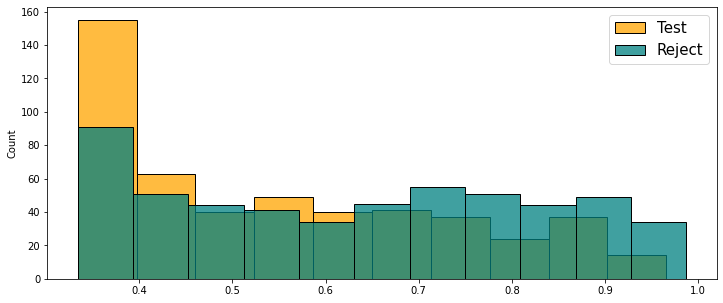

In [28]:
# softmax분포 확인
plt.figure(figsize=(12,5))
sns.histplot(test_msp, label='Test', color='orange')
sns.histplot(reject_msp, label='Reject', color='teal')
plt.legend(fontsize=15)
plt.show()

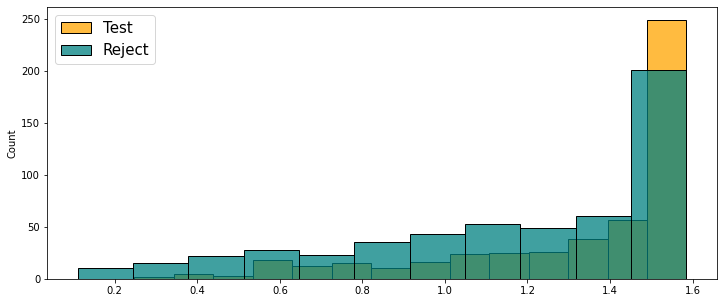

In [29]:
#entropy 분포 확인

plt.figure(figsize=(12,5))
sns.histplot(test_entropy, label='Test', color='orange')
sns.histplot(reject_entropy, label='Reject', color='teal')
plt.legend(fontsize=15)
plt.show()

### OpenMax 적용

In [34]:
# data와 모델 가져오기
train_loader, _train_data = create_dataloader(TRAIN_PATH, 1, False)
target_class_num = len(os.listdir(TRAIN_PATH))

net = torchvision.models.resnet50(pretrained=True)
net.fc = torch.nn.Linear(
    net.fc.in_features,
    target_class_num
)

saved_weight_path = os.path.join(MODEL_PATH, 'classifier_acc_0.28200.pth')
net.load_state_dict(torch.load(saved_weight_path, map_location=device))
print('Successfully Loaded the Network Weight!')
net.eval()

net.to(device)

Successfully Loaded the Network Weight!


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
# activation vector 뽑아오기

train_preds = list()
train_actvecs = list()
train_outputs_softmax = list()
train_labels = list()

with torch.no_grad():
  for idx, (img, label) in enumerate(train_loader):
      img = img.to(device)
      label = label.to(device)

      out = net(img)
      out_actvec = out.cpu().detach().numpy()[0]
      out_softmax = torch.softmax(out, 1).cpu().detach().numpy()[0]
      out_pred = int(torch.argmax(out).cpu().detach().numpy())
      out_label = int(label.cpu().detach().numpy())

      train_actvecs.append(out_actvec) # component 1: softmax 전의 Activation Vector
      train_preds.append(out_pred) # componenet 2: 각 데이터에 대한 예측값
      train_outputs_softmax.append(out_softmax) # component 3: 각 데이터에 대한 softmax 확률
      train_labels.append(out_label) # component 4: 각 데이터에 대한 Label (정답)

train_actvecs = np.asarray(train_actvecs)
train_preds = np.asarray(train_preds)
train_outputs_softmax = np.asarray(train_outputs_softmax)
train_labels = np.asarray(train_labels)

In [36]:
# 정답을 맞힌 액티베이션 벡터만 사용
# 어차피 전부 정답이니 사용 안함 테스트 시험
# 다음번에 할때에는 정답을 하나 만들고 하나는 다른 클래스 만들어서 시험해보자

# train_correct_actvecs = train_actvecs[train_labels==train_preds]
# train_correct_labels = train_labels[train_labels==train_preds]
# print('Activation vector: ', train_correct_actvecs.shape)
# print('Labels: ', train_correct_labels.shape)

# 그냥 모든 벡터 사용
train_correct_actvecs = train_actvecs
train_correct_labels = train_labels
print('Activation vector: ', train_correct_actvecs.shape)
print('Labels: ', train_correct_labels.shape)

Activation vector:  (2000, 3)
Labels:  (2000,)


In [37]:
# 이상치의 weibull 분포 그래프 만들기
class_means = list()
dist_to_means = list()
mr_models = {}

for class_idx in np.unique(train_labels):
    
    print('class_idx: ', class_idx)
    class_act_vec = train_correct_actvecs[train_correct_labels==class_idx]
    print(class_act_vec.shape)
    
    class_mean = class_act_vec.mean(axis=0)
    class_means.append(class_mean)
    
    dist_to_mean = np.square(class_act_vec - class_mean).sum(axis=1) # 각 activation vector의 거리를 계산
    dist_to_mean_sorted = np.sort(dist_to_mean).astype(np.float64) # 거리를 기준으로 오름차순 정렬
    dist_to_means.append(dist_to_mean_sorted)

    shape, loc, scale = stats.weibull_max.fit(dist_to_mean_sorted[-100:]) # 거리가 가장 먼 100개를 사용하여 모수 추출
    
    mr_models[str(class_idx)] = {
        'shape':shape,
        'loc':loc,
        'scale':scale
    }
    
class_means = np.asarray(class_means)

class_idx:  0
(1000, 3)
class_idx:  1
(500, 3)
class_idx:  2
(500, 3)


In [38]:
# 오픈 맥스 적용

def compute_openmax(actvec, class_means, mr_models):
    dist_to_mean = np.square(actvec - class_means).sum(axis=1)

    scores = list()
    for class_idx in range(len(class_means)):
        params = mr_models[str(class_idx)]
        score = stats.weibull_max.cdf(
            dist_to_mean[class_idx],
            params['shape'],
            params['loc'],
            params['scale']
        )
        scores.append(score)
    scores = np.asarray(scores)
    
    weight_on_actvec = 1 - scores # 각 class별 가중치
    rev_actvec = np.concatenate([
        weight_on_actvec * actvec, # known class에 대한 가중치 곱
        [((1-weight_on_actvec) * actvec).sum()] # unknown class에 새로운 계산식
    ])
    
    openmax_prob = np.exp(rev_actvec) / np.exp(rev_actvec).sum()
    return openmax_prob


In [39]:
# inference 함수
def inference(actvec, threshold, target_class_num, class_means, mr_models):
    openmax_prob = compute_openmax(actvec, class_means, mr_models)
    openmax_softmax = np.exp(openmax_prob)/sum(np.exp(openmax_prob))

    pred = np.argmax(openmax_softmax)
    if np.max(openmax_softmax) < threshold:
        pred = target_class_num
    return pred    

In [40]:
# threshold 탐색

def inference_dataloader(net, data_loader, threshold, target_class_num, class_means, mr_models, is_reject=False):
    result_preds = list()
    result_labels = list()

    with torch.no_grad():
      for idx, (img, label) in enumerate(data_loader):
          img = img.to(device)
          label = label.to(device)

          out = net(img)
          out_actvec = out.cpu().detach().numpy()[0]
          out_softmax = torch.softmax(out, 1).cpu().detach().numpy()[0]
          out_label = int(label.cpu().detach().numpy())

          pred = inference(out_actvec, threshold, target_class_num, class_means, mr_models)
      
          result_preds.append(pred)
          if is_reject:
              result_labels.append(target_class_num)
          else:
              result_labels.append(out_label)

    return result_preds, result_labels

In [41]:
# threshold 0.35로 탐색
test_loader, _test_data = create_dataloader(TEST_PATH, 1, False)
reject_loader, _reject_data = create_dataloader(REJECT_PATH, 1, False)
target_class_num = len(os.listdir(TEST_PATH))

test_preds, test_labels = inference_dataloader(net, test_loader, 0.35, target_class_num, class_means, mr_models)
reject_preds, reject_labels = inference_dataloader(net, reject_loader, 0.35, target_class_num, class_means, mr_models, is_reject=True)

print('Test Accuracy: ', accuracy_score(test_labels, test_preds))
print('Reject Accuracy: ', accuracy_score(reject_labels, reject_preds))

Test Accuracy:  0.004
Reject Accuracy:  0.8218923933209648


In [35]:
# threshold 0.4
test_preds, test_labels = inference_dataloader(net, test_loader, 0.4, target_class_num, class_means, mr_models)
reject_preds, reject_labels = inference_dataloader(net, reject_loader, 0.4, target_class_num, class_means, mr_models, is_reject=True)

print('Test Accuracy: ', accuracy_score(test_labels, test_preds))
print('Reject Accuracy: ', accuracy_score(reject_labels, reject_preds))

Test Accuracy:  0.006
Reject Accuracy:  0.9814471243042672


In [36]:
# threshold 0.5
test_preds, test_labels = inference_dataloader(net, test_loader, 0.5, target_class_num, class_means, mr_models)
reject_preds, reject_labels = inference_dataloader(net, reject_loader, 0.4, target_class_num, class_means, mr_models, is_reject=True)

print('Test Accuracy: ', accuracy_score(test_labels, test_preds))
print('Reject Accuracy: ', accuracy_score(reject_labels, reject_preds))

Test Accuracy:  0.0
Reject Accuracy:  0.9814471243042672


In [37]:
# 0.37
test_preds, test_labels = inference_dataloader(net, test_loader, 0.37, target_class_num, class_means, mr_models)
reject_preds, reject_labels = inference_dataloader(net, reject_loader, 0.4, target_class_num, class_means, mr_models, is_reject=True)

print('Test Accuracy: ', accuracy_score(test_labels, test_preds))
print('Reject Accuracy: ', accuracy_score(reject_labels, reject_preds))

Test Accuracy:  0.036
Reject Accuracy:  0.9814471243042672


In [38]:
test_preds, test_labels = inference_dataloader(net, test_loader, 0.2, target_class_num, class_means, mr_models)
reject_preds, reject_labels = inference_dataloader(net, reject_loader, 0.4, target_class_num, class_means, mr_models, is_reject=True)

print('Test Accuracy: ', accuracy_score(test_labels, test_preds))
print('Reject Accuracy: ', accuracy_score(reject_labels, reject_preds))

Test Accuracy:  0.334
Reject Accuracy:  0.9814471243042672


In [39]:
test_preds, test_labels = inference_dataloader(net, test_loader, 0.1, target_class_num, class_means, mr_models)
reject_preds, reject_labels = inference_dataloader(net, reject_loader, 0.4, target_class_num, class_means, mr_models, is_reject=True)

print('Test Accuracy: ', accuracy_score(test_labels, test_preds))
print('Reject Accuracy: ', accuracy_score(reject_labels, reject_preds))

Test Accuracy:  0.334
Reject Accuracy:  0.9814471243042672


In [44]:
test_preds, test_labels = inference_dataloader(net, test_loader, 0.38, target_class_num, class_means, mr_models)
reject_preds, reject_labels = inference_dataloader(net, reject_loader, 0.38, target_class_num, class_means, mr_models, is_reject=True)

print('Test Accuracy: ', accuracy_score(test_labels, test_preds))
print('Reject Accuracy: ', accuracy_score(reject_labels, reject_preds))

Test Accuracy:  0.03
Reject Accuracy:  0.8942486085343229


### 회고
- 더트 이미지에대한 분류가 생각 보다 잘된다
- test 이미지는  원래가 분류가 어려워서 한쪽으로 몰렷기때문에 0.34 1/3 이 나온것으로 보인다.
- train data 하나로 바꾸고 data 이외의 카테고리를 넣어줘서 실험해보자
- 예를 들어 train 0 을 컵홀더 이미지 train 1을 실내 이미지 reject를 더러운 이미지로 넣으면 컵홀더를 분류를 잘해내는지 test accuracy와, 비슷한 이미지인 컵홀더와 컵홀더가 더러운 상태의 이미지를 구분 할수 있는지 reject accuracy로 확인이 가능할 것으로 보인다.